In [154]:
#import the libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [155]:
#Load preprocessed data
df = pd.read_csv('../data/processed/flight_delays_preprocessed.csv')
df.head()

,DelayMinutes,Distance,ScheduledDuration,DepartureHour,DepartureDay,DepartureMonth,IsWeekend,Airline_Encoded,Origin_Encoded,Destination_Encoded,AircraftType_Encoded
0,8,-0.623216,1.494821,-0.501948,6,9,1,3,4,2,1
1,2,-0.653002,1.234014,-0.212971,6,9,1,1,3,2,0
2,14,1.698826,-1.586569,0.653959,6,9,1,2,1,4,1
3,0,-0.174058,-1.557590,0.364982,6,9,1,1,4,0,2
4,24,0.886290,1.011845,-1.513366,6,9,1,1,3,3,1


In [156]:
#Define features and target variable
TARGET = 'DelayMinutes'

x = df.drop(columns=[TARGET])
y = df[TARGET]

In [157]:
#Train–Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [158]:
#Train RandomForest Regressor
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(x_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [159]:
#prediction
y_pred = rf.predict(x_test)

In [164]:
#Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 

print(f"MAE  : {mae:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")


MAE  : 8.96
MSE  : 103.28
RMSE : 10.16


In [161]:
#Hyperparameter Tuning
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [165]:
#Model training with best parameters
final_model = grid_search.best_estimator_
final_model.fit(x_train, y_train)

final_pred = final_model.predict(x_test)

final_mae = mean_absolute_error(y_test, final_pred)
final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, final_pred))


print(f"Final MAE  : {final_mae:.2f}")
print(f"Final MSE  : {final_mse:.2f}")
print(f"Final RMSE : {final_rmse:.2f}")

Final MAE  : 8.84
Final MSE  : 99.59
Final RMSE : 9.98


In [ ]:
#Feature Importance
feature_importances = pd.Series(final_model.feature_importances_, index=x.columns)
feature_importances = feature_importances.sort_values(ascending=False)

feature_importances.head(10)

Distance                0.301685
ScheduledDuration       0.240570
DepartureHour           0.136299
DepartureMonth          0.069403
Destination_Encoded     0.060314
Origin_Encoded          0.059602
Airline_Encoded         0.049194
DepartureDay            0.039892
AircraftType_Encoded    0.037818
IsWeekend               0.005222
dtype: float64

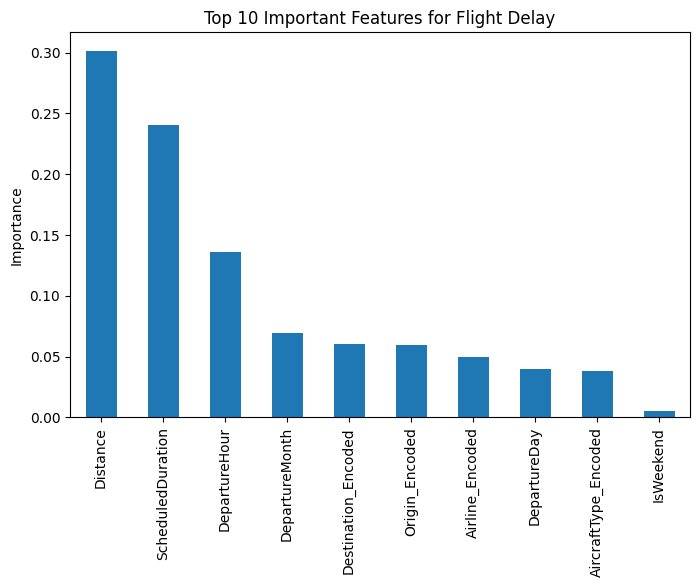

In [ ]:
plt.figure(figsize=(8,5))
feature_importances.head(10).plot(kind="bar")
plt.title("Top 10 Important Features for Flight Delay")
plt.ylabel("Importance")
plt.show()


In [162]:
#save the model
joblib.dump(final_model, "../models/flight_delay_model.pkl")


['../models/flight_delay_model.pkl']

In [163]:
#Load and test the saved model
loaded_model = joblib.load("../models/flight_delay_model.pkl")

loaded_model.predict(x_test.iloc[:5])


array([ 8.30579793, 10.40136664, 12.62216736, 10.56027719, 11.39531375])